# Baseline

In this notebook we avoid doig the preprocess and we directly build the final model just selecting the same variables as the paper. This will be our baseline to compare future results.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, ConfusionMatrixDisplay

In [2]:
df_alleles = pd.read_csv('oncoth1_with_n_risk_alleles.csv')

In [3]:
df = pd.read_csv('development_db_score_oncothromb.csv')

In [4]:
df_alleles['VTE'] = df['VTE'].values

# Compute Genetic Risk Score

We compute the Genetic Risk Score with the selected features.
A straightforward method to evaluate the GRS is to choose a number k of independent genetic variants with strong (i.e., genome-wide significance in other studies or datasets) association as risk predictors, and to calculate the GRS as the sum of the effect estimates (log odds ratios), βi, from a logistic regression analysis with additive genetic effect, multiplied by the number of risk alleles, Ni, for each locus: 

The paper selects the following variables: 
- rs4524
- rs6025
- rs2232698
- rs2227631
- rs268
- rs169713
- rs11696364
- rs5110
- rs6003

In [5]:
gen_predictors = ['rs4524', 'rs6025', 'rs2232698', 'rs2227631', 'rs268', 'rs169713', 'rs11696364', 'rs5110','rs6003']

In [6]:
#Select the risk alleles of the selected features
alleles_ = []
for element in gen_predictors:
    alleles_.append(element + '_n_risk_alleles')
alleles_.append('VTE')
alleles_.append('id')
df_alleles = df_alleles[alleles_].dropna()
df_alleles.head()

,rs4524_n_risk_alleles,rs6025_n_risk_alleles,rs2232698_n_risk_alleles,rs2227631_n_risk_alleles,rs268_n_risk_alleles,rs169713_n_risk_alleles,rs11696364_n_risk_alleles,rs5110_n_risk_alleles,rs6003_n_risk_alleles,VTE,id
0,1,0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1,1
1,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,2
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
3,2,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,4
4,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,5


### Compute Genetic Risk Score

In [7]:
from sklearn.linear_model import LogisticRegression

y = df_alleles['VTE']
X = df_alleles.drop(columns=['VTE', 'id'])

model = LogisticRegression(fit_intercept = True)
model.fit(X, y)

GRS = (model.coef_ * X).sum(axis=1) + model.intercept_
df_alleles['GRS'] = GRS

## Clinical Variables

- very high risk -> stomach, pancreas
- high risk -> lung, lymphoma, gynelocoligal, blader, testicular
- low risk -> colorectal
- platelet count >= 350x10^9/L -> high risk
- leukocyte count >= 11x10^9/L -> high risk

In [9]:
import re
def map_column(row, clinical_dict):
    row = str(row)
    for key, value in clinical_dict.items():
        if re.match(value[0], row):
            return key
    return 'No Clasificado'

In [10]:
def preprocess_clinical_features(df):
    df_clin = df.iloc[:, 1:21]
    cols_names_clin = df_clin.columns[1:]

    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Colorectal', 'primary_tumor_simplified'] = 0
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'NSCLC', 'primary_tumor_simplified'] = 1
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Oesophago-gastric', 'primary_tumor_simplified'] = 2
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Pancreatic', 'primary_tumor_simplified'] = 2

    df_clin.loc[df_clin['leukocytes'] < 11000, 'leukocytes'] = 0
    df_clin.loc[df_clin['leukocytes'] >= 11000, 'leukocytes'] = 1
    df_clin.loc[df_clin['platelets'] < 350000, 'platelets'] = 0
    df_clin.loc[df_clin['platelets'] >= 350000, 'platelets'] = 1

    bmi_risk = {
        1: [r"(Obese: BMI > 30 kg/m2)|( Overweight: BMI ~25-29.9 Kg/m2)"],
        0: [r"(Normal: BMI ~ 18.5-24.9 Kg/m2)|(Underweight: BMI < 18.5 Kg/m2)"],
    }

    tnm_stage_detailed_risk = {
        1: [r"(IA)|(IB)"],
        2: [r"(IIB)|(IIA)|(IIC)"],
        3: [r"(III)|(IIIB)|(IIIA)|(IIIC)"],
        4: [r"(IVB)|(IVA)|(IV)"],
    }


    df_clin['bmi_category'] = df_clin['bmi_category'].apply(lambda x: map_column(x, bmi_risk))
    df_clin['tnm_stage_detailed'] = df_clin['tnm_stage_detailed'].apply(lambda x: map_column(x, tnm_stage_detailed_risk))

    return df_clin

In [11]:
df_clin = preprocess_clinical_features(df)

### Get the clinical variables following the paper (without p-value selection )

In [12]:
# Drop the variables that are not mentioned in the paper
df_clin = df_clin.drop(['pregnancy', 'oral_contraceptives', 'hemoglobin'], axis=1)
df_clin['id'] = df['id'].values

Select the same predictors as the paper

In [13]:
clin_predictors = ['tnm_stage_detailed', 'bmi_category', 'primary_tumor_simplified', 'id', 'VTE']
df_clin = df_clin[clin_predictors]

In [14]:
pred = ['id', 'GRS', 'VTE']
predictors = df_alleles[pred]

In [15]:
df_ft = predictors.merge(df_clin, on=['id','VTE'])
df_ft.head()

,id,GRS,VTE,tnm_stage_detailed,bmi_category,primary_tumor_simplified
0,1,-0.309952,1,4,1,2
1,2,-1.015882,0,2,0,2
2,3,-0.994715,0,3,1,2
3,4,-2.016533,0,2,0,2
4,5,-1.283673,0,1,0,2


In [16]:
df = df_ft.drop(['id'],axis=1)

### Train the final model

In [19]:
y = df_ft['VTE'].values
X = df_ft.drop(['VTE', 'id'], axis=1)
# Train a logistic regression model
model = LogisticRegression()
model.fit(X, y)
# Compute the AUC-ROC score for the observed data
y_pred =  (model.predict_proba(X)[:,1] >= 0.3).astype(bool) 
auc_obs = roc_auc_score(y, y_pred)
print(auc_obs)

0.6599147121535182


Compute evaluation metrics

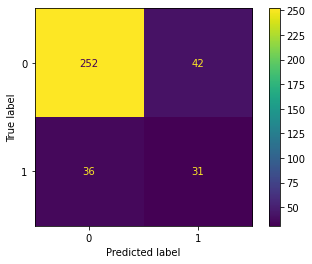

Specificity: 0.8571428571428571
Sensitivity (Recall): 0.4626865671641791
Positive Likelihood Ratio: 3.2388059701492526
Negative Likelihood Ratio: 0.6268656716417911
Positive Predictive Value (Precision): 0.4246575342465753
Negative Predictive Value: 0.875


In [20]:
# Compute confusion matrix
cm = confusion_matrix(y, np.round(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

# Extract TP, TN, FP, and FN
tn, fp, fn, tp = cm.ravel()

# Compute specificity, sensitivity, positive likelihood ratio, negative likelihood ratio, positive predictive value, and negative predictive value
specificity = tn / (tn + fp)
sensitivity = recall = tp / (tp + fn)
positive_likelihood_ratio = sensitivity / (1 - specificity)
negative_likelihood_ratio = (1 - sensitivity) / specificity
ppv =precision_score(y, np.round(y_pred))
npv = tn / (tn + fn)

print("Specificity:", specificity)
print("Sensitivity (Recall):", sensitivity)
print("Positive Likelihood Ratio:", positive_likelihood_ratio)
print("Negative Likelihood Ratio:", negative_likelihood_ratio)
print("Positive Predictive Value (Precision):", ppv)
print("Negative Predictive Value:", npv)


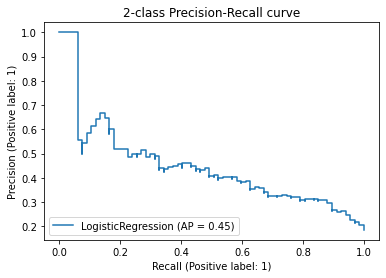

In [21]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, X, y, name="LogisticRegression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")